## Model Evaluation

This notebook evaluates a model, tune parameters and builds the final model.

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

lets not forget to remove the features which will not be present in real life situation. <br>
as well as using the proper target, as explained in the FE.ipynb file.

In [2]:
df = pd.read_csv('../data/FE_data.csv')
df.drop(['consultation_start_time','consultation_end_time','duration','patient'],1,inplace=True)

In [3]:
validation_period = 10

validation_days = np.arange(max(df['day'])-validation_period, max(df['day'])+1)

train_X = df.loc[df['day'].isin(validation_days)==False].drop('day',1)
train_y = np.log(train_X.pop('actual_duration'))

valid_X = df.loc[df['day'].isin(validation_days)].drop('day',1)
valid_y = np.log(valid_X.pop('actual_duration'))

full_X = df.drop('day',1)
full_y = np.log(full_X.pop('actual_duration'))

In [4]:
lgb_train = lgb.Dataset(train_X, train_y)
lgb_valid = lgb.Dataset(valid_X, valid_y, reference=lgb_train)

In [5]:
feature_name = list(train_X.columns)

np.random.seed(42)

params = {
    'boosting_type': 'gbrt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.001,
    'feature_fraction': 0.9,
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=[lgb_train,lgb_valid],  # eval training data
                early_stopping_rounds = 200,
                verbose_eval=500)

Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 0.454217	valid_1's rmse: 0.500716
[1000]	training's rmse: 0.40354	valid_1's rmse: 0.449649
[1500]	training's rmse: 0.37842	valid_1's rmse: 0.426696
[2000]	training's rmse: 0.363451	valid_1's rmse: 0.414382
[2500]	training's rmse: 0.352888	valid_1's rmse: 0.406486
[3000]	training's rmse: 0.344038	valid_1's rmse: 0.400169
[3500]	training's rmse: 0.33674	valid_1's rmse: 0.395293
[4000]	training's rmse: 0.330509	valid_1's rmse: 0.391457
[4500]	training's rmse: 0.325045	valid_1's rmse: 0.388729
[5000]	training's rmse: 0.320452	valid_1's rmse: 0.387062
[5500]	training's rmse: 0.316255	valid_1's rmse: 0.385372
[6000]	training's rmse: 0.312633	valid_1's rmse: 0.384388
[6500]	training's rmse: 0.309404	valid_1's rmse: 0.383873
[7000]	training's rmse: 0.306505	valid_1's rmse: 0.383539
Early stopping, best iteration is:
[7095]	training's rmse: 0.305995	valid_1's rmse: 0.383534


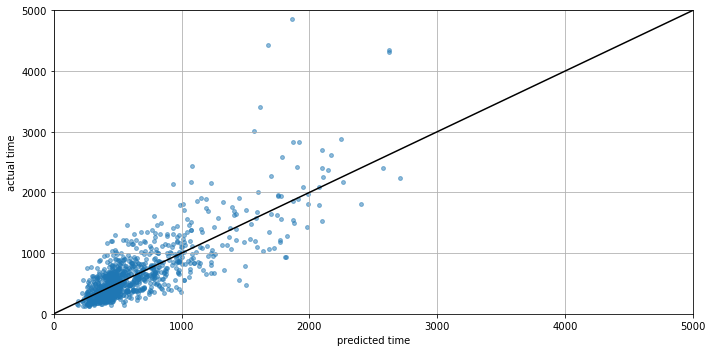

In [6]:
plt.figure(figsize=(10,5))
plt.scatter(np.exp(gbm.predict(valid_X)), np.exp(valid_y), s=15, alpha=0.5)
plt.plot(np.arange(5000),np.arange(5000), color='black')
plt.xlim((0,5000))
plt.ylim((0,5000))
plt.xlabel('predicted time')
plt.ylabel('actual time')
plt.grid()
plt.tight_layout()

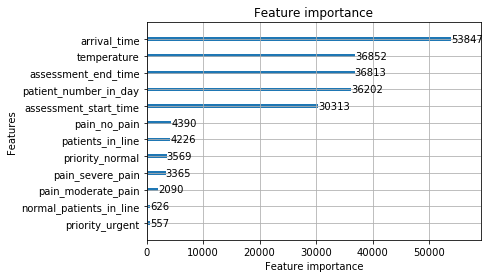

In [7]:
lgb.plot_importance(gbm)

In [8]:
mean_squared_error(np.exp(valid_y),np.exp(gbm.predict(valid_X)))**(1/2)

299.13655284653629

a RMSE of ~300 s. thats about 5 minutes off. not bad. <br>

most important features are shown in the graph above. <br>
while some features where naturally taken off due obvious reasons (day, patient) no further feature selection technic was attempted, as this is supposed to be a simple exercise. <br>

the actual model uses the entire data set to train. <br>
a different notebook will be used to make a data preparation pipeline as well as a model and predict/evaluate results. <br>

In [9]:
lgb_full = lgb.Dataset(full_X, full_y)

np.random.seed(42)

model = lgb.train(params,
                lgb_full,
                num_boost_round=6200)

In [10]:
model.save_model('model.txt')